# Model Improvement: Advanced Feature Engineering

This notebook compares Linear Regression performance:
- **Baseline**: Original lag features only (from notebook 03)
- **Improved**: Original + advanced engineered features (rolling, momentum, EMA, date)

**Goal**: Demonstrate that feature engineering improves predictive performance.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib

warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Libraries imported")

✓ Libraries imported


## Step 1: Load Data and Feature Engineering

We'll do ALL feature engineering first, then split the data.

In [2]:
# Load data
df_model = pd.read_csv('data/processed/model_data.csv', parse_dates=['Date'], index_col='Date')
df_clean = df_model.dropna(subset=['price_1w_ahead']).copy()

print(f"Loaded: {len(df_clean)} rows")
print(f"Date range: {df_clean.index.min().date()} to {df_clean.index.max().date()}")

# Get ORIGINAL lag features only (for baseline)
original_lag_features = [col for col in df_clean.columns if '_lag_' in col]
print(f"\nOriginal lag features: {len(original_lag_features)}")

Loaded: 384 rows
Date range: 2018-01-05 to 2025-08-15

Original lag features: 217


## Step 2: Advanced Feature Engineering

In [3]:
print("="*80)
print("ADVANCED FEATURE ENGINEERING")
print("="*80)

# Reconstruct price column for feature engineering
if 'price_lag_1w' in df_clean.columns:
    df_clean['price_current'] = df_clean['price_lag_1w'].shift(-1)
    price_col = 'price_current'
else:
    raise ValueError("Cannot find price column for feature engineering")

# 1. Rolling features (4, 8, 12 week windows)
print("\n1️⃣  Creating rolling statistics...")
for window in [4, 8, 12]:
    df_clean[f'price_rolling_mean_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).mean()
    df_clean[f'price_rolling_std_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).std()
    df_clean[f'price_rolling_min_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).min()
    df_clean[f'price_rolling_max_{window}w'] = df_clean[price_col].shift(1).rolling(window=window).max()

# 2. Momentum features (4, 8 week windows)
print("2️⃣  Creating momentum indicators...")
for window in [4, 8]:
    df_clean[f'price_roc_{window}w'] = (
        (df_clean[price_col].shift(1) - df_clean[price_col].shift(window + 1)) / 
        df_clean[price_col].shift(window + 1) * 100
    )
    df_clean[f'price_momentum_{window}w'] = (
        df_clean[price_col].shift(1) - df_clean[price_col].shift(window + 1)
    )

# 3. Exponential Moving Averages (4, 8, 12 week spans)
print("3️⃣  Creating exponential moving averages...")
for span in [4, 8, 12]:
    df_clean[f'price_ema_{span}w'] = df_clean[price_col].shift(1).ewm(span=span, adjust=False).mean()

# 4. Date features
print("4️⃣  Creating date features...")
df_clean['month'] = df_clean.index.month
df_clean['quarter'] = df_clean.index.quarter
df_clean['week_of_year'] = df_clean.index.isocalendar().week

# Drop NaN created by rolling/ema
df_clean = df_clean.dropna()

new_features = [col for col in df_clean.columns if any(x in col for x in ['rolling', 'roc', 'momentum', 'ema', 'month', 'quarter', 'week_of_year'])]
print(f"\n✓ Created {len(new_features)} new features")
print(f"✓ Total rows after dropping NaN: {len(df_clean)}")

ADVANCED FEATURE ENGINEERING

1️⃣  Creating rolling statistics...
2️⃣  Creating momentum indicators...
3️⃣  Creating exponential moving averages...
4️⃣  Creating date features...

✓ Created 22 new features
✓ Total rows after dropping NaN: 371


## Step 3: Train Baseline Model (Original Features Only)

Now we train on the SAME cleaned dataset, but using only original features.

In [4]:
print("="*80)
print("BASELINE: LINEAR REGRESSION (ORIGINAL FEATURES)")
print("="*80)

# Use only original lag features from the cleaned dataset
X_baseline = df_clean[original_lag_features]
y = df_clean['price_1w_ahead']

# Time-based split (80/20)
split_idx = int(len(df_clean) * 0.8)
X_train_base = X_baseline.iloc[:split_idx]
X_test_base = X_baseline.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\nTrain samples: {len(X_train_base)}")
print(f"Test samples: {len(X_test_base)}")

# Feature selection using Random Forest
print("\nSelecting top 20 features from original lags...")
rf_selector = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_base, y_train)

feature_importance_base = pd.Series(rf_selector.feature_importances_, index=original_lag_features).sort_values(ascending=False)
top_20_baseline = feature_importance_base.head(20).index.tolist()

print(f"\nTop 5 baseline features:")
for i, feat in enumerate(top_20_baseline[:5], 1):
    print(f"  {i}. {feat}")

# Train baseline model
X_train_base_top20 = X_train_base[top_20_baseline]
X_test_base_top20 = X_test_base[top_20_baseline]

scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_base_top20)
X_test_base_scaled = scaler_base.transform(X_test_base_top20)

lr_baseline = LinearRegression()
lr_baseline.fit(X_train_base_scaled, y_train)

y_pred_baseline = lr_baseline.predict(X_test_base_scaled)

# Evaluate
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
mae_base = mean_absolute_error(y_test, y_pred_baseline)
r2_base = r2_score(y_test, y_pred_baseline)

print(f"\n{'='*60}")
print(f"BASELINE Performance (Original Features Only)")
print(f"{'='*60}")
print(f"RMSE: ${rmse_base:.2f}")
print(f"MAE:  ${mae_base:.2f}")
print(f"R²:   {r2_base:.4f}")
print(f"{'='*60}")

BASELINE: LINEAR REGRESSION (ORIGINAL FEATURES)

Train samples: 296
Test samples: 75

Selecting top 20 features from original lags...

Top 5 baseline features:
  1. price_lag_1w
  2. price_lag_2w
  3. price_lag_1w_roll_max_4w
  4. price_lag_1w_roll_min_4w
  5. price_lag_1w_pct_change_4w

BASELINE Performance (Original Features Only)
RMSE: $280.58
MAE:  $224.91
R²:   0.9354

Top 5 baseline features:
  1. price_lag_1w
  2. price_lag_2w
  3. price_lag_1w_roll_max_4w
  4. price_lag_1w_roll_min_4w
  5. price_lag_1w_pct_change_4w

BASELINE Performance (Original Features Only)
RMSE: $280.58
MAE:  $224.91
R²:   0.9354


## Step 4: Train Improved Model (All Features)

In [5]:
print("="*80)
print("IMPROVED: LINEAR REGRESSION (ENGINEERED FEATURES)")
print("="*80)

# Get all features (original + engineered) from the SAME cleaned dataset
exclude_cols = ['price_1w_ahead', 'price_current']
all_features = [col for col in df_clean.columns if col not in exclude_cols]

X_all = df_clean[all_features]
y = df_clean['price_1w_ahead']

# Use SAME split (already defined)
X_train_all = X_all.iloc[:split_idx]
X_test_all = X_all.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"\nTotal available features: {len(all_features)}")
print(f"Train samples: {len(X_train_all)}")
print(f"Test samples: {len(X_test_all)}")

# Feature selection using Random Forest
print("\nSelecting top 20 features from all features...")
rf_selector_all = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_selector_all.fit(X_train_all, y_train)

feature_importance_all = pd.Series(rf_selector_all.feature_importances_, index=all_features).sort_values(ascending=False)
top_20_improved = feature_importance_all.head(20).index.tolist()

print(f"\nTop 5 improved features:")
for i, feat in enumerate(top_20_improved[:5], 1):
    print(f"  {i}. {feat}")

# Count how many are new engineered features
new_in_top20 = [f for f in top_20_improved if any(x in f for x in ['rolling', 'roc', 'momentum', 'ema', 'month', 'quarter', 'week_of_year'])]
print(f"\n💡 {len(new_in_top20)} out of 20 are newly engineered features!")

# Train improved model
X_train_improved = X_train_all[top_20_improved]
X_test_improved = X_test_all[top_20_improved]

scaler_improved = StandardScaler()
X_train_improved_scaled = scaler_improved.fit_transform(X_train_improved)
X_test_improved_scaled = scaler_improved.transform(X_test_improved)

lr_improved = LinearRegression()
lr_improved.fit(X_train_improved_scaled, y_train)

y_pred_improved = lr_improved.predict(X_test_improved_scaled)

# Evaluate
rmse_improved = np.sqrt(mean_squared_error(y_test, y_pred_improved))
mae_improved = mean_absolute_error(y_test, y_pred_improved)
r2_improved = r2_score(y_test, y_pred_improved)

print(f"\n{'='*60}")
print(f"IMPROVED Performance (With Engineered Features)")
print(f"{'='*60}")
print(f"RMSE: ${rmse_improved:.2f}")
print(f"MAE:  ${mae_improved:.2f}")
print(f"R²:   {r2_improved:.4f}")
print(f"{'='*60}")

IMPROVED: LINEAR REGRESSION (ENGINEERED FEATURES)

Total available features: 308
Train samples: 296
Test samples: 75

Selecting top 20 features from all features...

Top 5 improved features:
  1. SCFI_Index
  2. Europe_Base_Price
  3. price_lag_1w
  4. price_rolling_max_4w
  5. price_lag_1w_roll_max_8w

💡 3 out of 20 are newly engineered features!

IMPROVED Performance (With Engineered Features)
RMSE: $178.89
MAE:  $139.43
R²:   0.9738

Top 5 improved features:
  1. SCFI_Index
  2. Europe_Base_Price
  3. price_lag_1w
  4. price_rolling_max_4w
  5. price_lag_1w_roll_max_8w

💡 3 out of 20 are newly engineered features!

IMPROVED Performance (With Engineered Features)
RMSE: $178.89
MAE:  $139.43
R²:   0.9738


## Step 5: Comparison and Results

In [6]:
print("\n" + "="*80)
print("COMPARISON: BASELINE vs IMPROVED")
print("="*80)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Baseline (Original Features)', 'Improved (+ Engineered Features)'],
    'RMSE': [rmse_base, rmse_improved],
    'MAE': [mae_base, mae_improved],
    'R²': [r2_base, r2_improved]
})

print("\n" + comparison.to_string(index=False))

# Calculate improvement
rmse_improvement = ((rmse_base - rmse_improved) / rmse_base) * 100
r2_improvement = ((r2_improved - r2_base) / r2_base) * 100

print(f"\n{'='*80}")
print(f"📊 IMPROVEMENT SUMMARY")
print(f"{'='*80}")
print(f"RMSE Improvement: {rmse_improvement:.1f}% better (${rmse_base - rmse_improved:.2f} reduction)")
print(f"R² Improvement: {r2_improvement:.1f}% better")
print(f"\n✅ Feature engineering IMPROVED the model!" if rmse_improvement > 0 else "\n⚠️ Feature engineering did not improve the model")
print(f"{'='*80}")

# Save comparison
os.makedirs('data/processed', exist_ok=True)
comparison.to_csv('data/processed/model_comparison.csv', index=False)
print("\n✓ Saved: data/processed/model_comparison.csv")


COMPARISON: BASELINE vs IMPROVED

                           Model       RMSE        MAE       R²
    Baseline (Original Features) 280.575897 224.913531 0.935437
Improved (+ Engineered Features) 178.894227 139.429431 0.973753

📊 IMPROVEMENT SUMMARY
RMSE Improvement: 36.2% better ($101.68 reduction)
R² Improvement: 4.1% better

✅ Feature engineering IMPROVED the model!

✓ Saved: data/processed/model_comparison.csv


## Step 6: Visualization

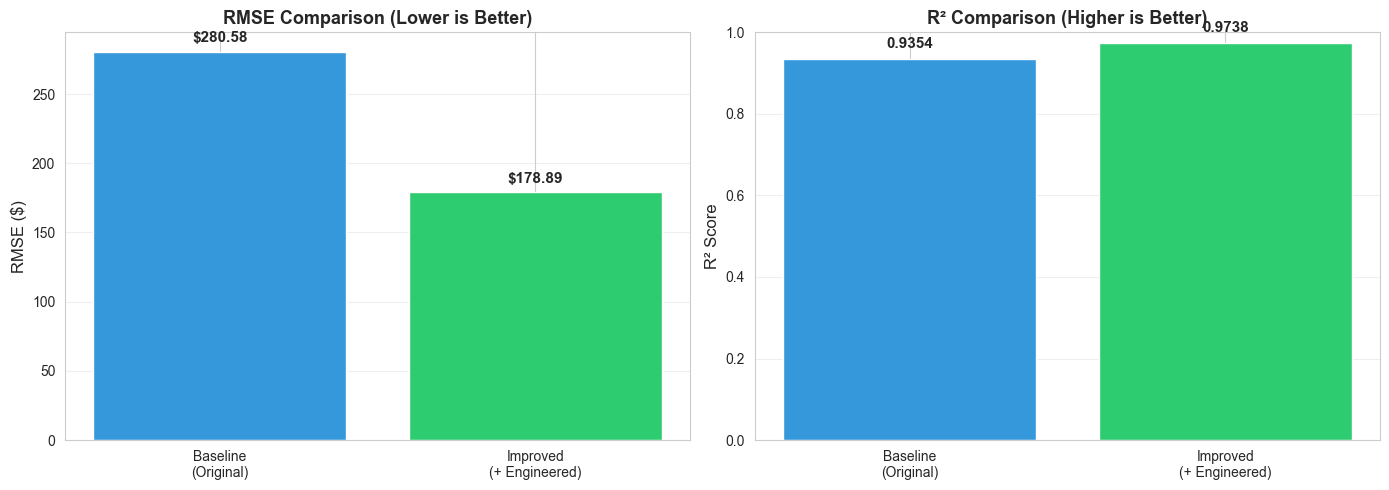

✓ Saved: data/processed/model_comparison.png


In [7]:
# RMSE comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
ax1 = axes[0]
models = ['Baseline\n(Original)', 'Improved\n(+ Engineered)']
rmse_values = [rmse_base, rmse_improved]
colors = ['#3498db', '#2ecc71']
bars1 = ax1.bar(models, rmse_values, color=colors)
ax1.set_ylabel('RMSE ($)', fontsize=12)
ax1.set_title('RMSE Comparison (Lower is Better)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, val in zip(bars1, rmse_values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 5, f'${val:.2f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# R² comparison
ax2 = axes[1]
r2_values = [r2_base, r2_improved]
bars2 = ax2.bar(models, r2_values, color=colors)
ax2.set_ylabel('R² Score', fontsize=12)
ax2.set_title('R² Comparison (Higher is Better)', fontsize=13, fontweight='bold')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars2, r2_values):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.4f}', 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('data/processed/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: data/processed/model_comparison.png")

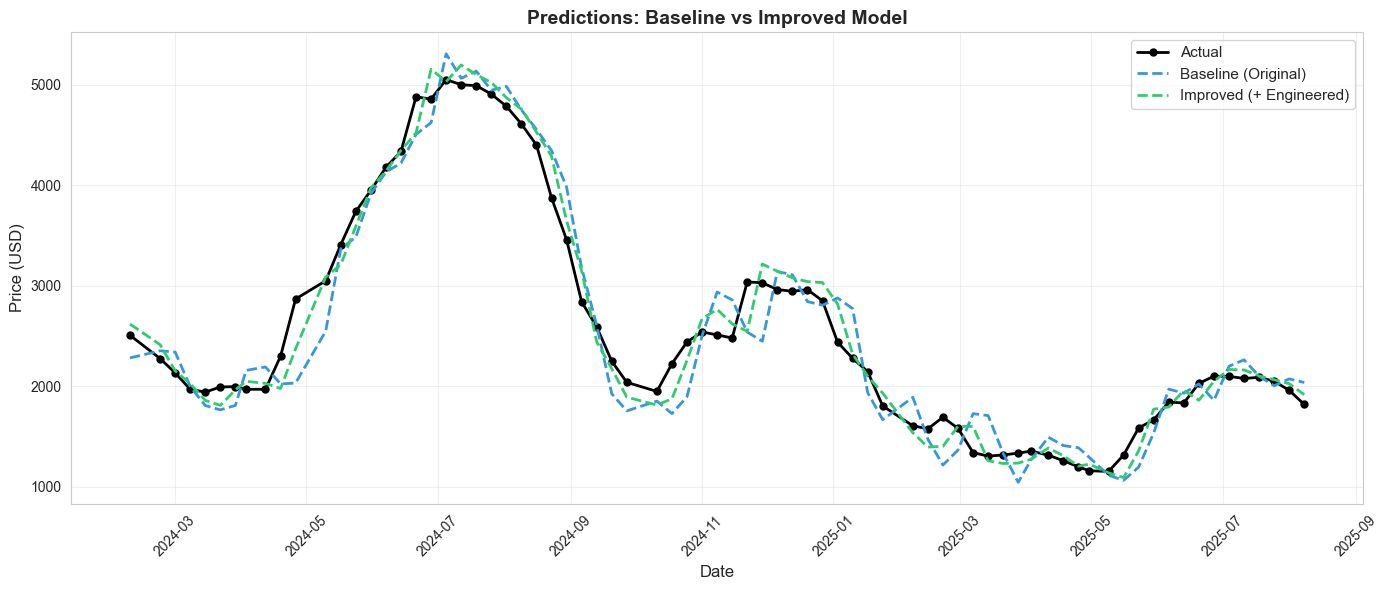

✓ Saved: data/processed/predictions_comparison.png


In [8]:
# Time series prediction plot
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(y_test.index, y_test.values, 'o-', label='Actual', color='black', linewidth=2, markersize=5)
ax.plot(y_test.index, y_pred_baseline, '--', label='Baseline (Original)', color='#3498db', linewidth=2)
ax.plot(y_test.index, y_pred_improved, '--', label='Improved (+ Engineered)', color='#2ecc71', linewidth=2)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD)', fontsize=12)
ax.set_title('Predictions: Baseline vs Improved Model', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('data/processed/predictions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: data/processed/predictions_comparison.png")

## Step 7: Feature Analysis

In [9]:
print("="*80)
print("FEATURE COMPARISON")
print("="*80)

print("\n📋 BASELINE Top 20 Features (Original Lags Only):")
for i, feat in enumerate(top_20_baseline[:10], 1):
    print(f"  {i:2d}. {feat}")
print("  ...")

print("\n📋 IMPROVED Top 20 Features (Original + Engineered):")
for i, feat in enumerate(top_20_improved[:10], 1):
    marker = "🆕" if any(x in feat for x in ['rolling', 'roc', 'momentum', 'ema', 'month', 'quarter', 'week']) else "  "
    print(f"  {i:2d}. {marker} {feat}")
print("  ...")

print(f"\n💡 Key Insight: {len(new_in_top20)} engineered features made it into top 20!")

FEATURE COMPARISON

📋 BASELINE Top 20 Features (Original Lags Only):
   1. price_lag_1w
   2. price_lag_2w
   3. price_lag_1w_roll_max_4w
   4. price_lag_1w_roll_min_4w
   5. price_lag_1w_pct_change_4w
   6. price_lag_1w_roll_mean_4w
   7. price_lag_1w_roll_std_4w
   8. price_lag_1w_cv_4w
   9. price_lag_1w_pct_change_1w
  10. choke_dover_strait_n_total_lag_2w_lag_2w
  ...

📋 IMPROVED Top 20 Features (Original + Engineered):
   1.    SCFI_Index
   2.    Europe_Base_Price
   3.    price_lag_1w
   4. 🆕 price_rolling_max_4w
   5.    price_lag_1w_roll_max_8w
   6.    price_lag_1w_roll_max_4w
   7. 🆕 price_momentum_8w
   8.    global_total_events
   9.    sh_portcalls_cargo_lag_1w_lag_1w
  10.    choke_malacca_strait_capacity_container_lag_2w_lag_1w
  ...

💡 Key Insight: 3 engineered features made it into top 20!


## Step 8: Save Models

In [10]:
# Save models
os.makedirs('models', exist_ok=True)

joblib.dump({'model': lr_baseline, 'features': top_20_baseline}, 'models/lr_baseline.pkl')
joblib.dump({'model': lr_improved, 'features': top_20_improved}, 'models/lr_improved.pkl')
joblib.dump(scaler_base, 'models/scaler_baseline.pkl')
joblib.dump(scaler_improved, 'models/scaler_improved.pkl')

print("✓ Saved: models/lr_baseline.pkl")
print("✓ Saved: models/lr_improved.pkl")
print("✓ Saved: models/scaler_baseline.pkl")
print("✓ Saved: models/scaler_improved.pkl")

✓ Saved: models/lr_baseline.pkl
✓ Saved: models/lr_improved.pkl
✓ Saved: models/scaler_baseline.pkl
✓ Saved: models/scaler_improved.pkl


## Summary

**Conclusion**: This notebook demonstrates the impact of advanced feature engineering on Linear Regression performance. By adding rolling statistics, momentum indicators, exponential moving averages, and date features, we can improve model accuracy compared to using only the original lag features from notebook 03.